In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
path = '/content/drive/MyDrive/data/'

In [ ]:
# @title Phân ngưỡng thủ công
def nguong_thu_cong(anh_vao, theta, max=255, min=0):
    anh_ra = np.where(anh_vao >= theta, max, min)
    return anh_ra

In [ ]:
# @title Phân ngưỡng tự động
def nguong_tu_dong(anh_vao):
    # Lấy các giá trị mức xám, số lượng mức xám tương ứng của ảnh vào và sắp xếp tăng
    g, hg = np.unique(anh_vao, return_counts=True)

    # Tính t(g) là số điểm ảnh có mức xám ≤ g
    tg = np.cumsum(hg)

    # Tính tổng i * h(i)
    tong_i_hi = np.cumsum(g * hg)

    # Tính m(g) = 1 / t(g) * sum_i_hi
    mg = [1 / tg[i] * tong_i_hi[i] for i in np.arange(np.size(g))]

    # Tính f = t(g) / (mxn - t(g) * (m(g) - m(g-1))**2
    mxn = np.shape(anh_vao)[0] * np.shape(anh_vao)[1]
    fg = [tg[i] / (mxn - tg[i]) * (mg[i] - mg[-1]) ** 2 for i in np.arange(np.size(g) - 1)]

    # Tìm ngưỡng tối ưu theta
    theta = g[np.argmax(fg)]

    return theta

In [ ]:
# @title Phân ngưỡng Otsu
def nguong_otsu(anh_vao):
    # Lấy các giá trị mức xám, số lượng mức xám tương ứng của ảnh vào và sắp xếp tăng
    g, hg = np.unique(anh_vao, return_counts=True)

    # Tính tần suất xuất hiện của từng mức xám
    p = hg / anh_vao.shape[0] / anh_vao.shape[1]

    # Khởi tạo tập phương sai, P1 và P2
    phuong_sai = np.zeros_like(g, dtype=float)
    P1 = 0
    P2 = 1
    m1_tu = 0
    m2_tu = mg = np.sum(g * p)  # Tính giá trị trung bình của ảnh mg

    # Vòng lặp để xây dựng tập phương sai
    for k in np.arange(len(g) - 1):
        # Tính tỷ lệ số lượng pixel nhỏ hơn ngưỡng và lớn hơn ngưỡng
        P1 += p[k]
        P2 -= p[k]
        # Tính trung bình cộng của giá trị mức xám trong hai phân lớp
        m1_tu += g[k] * p[k]
        m2_tu -= g[k] * p[k]
        m1 = m1_tu / P1
        m2 = m2_tu / P2

        # Tính phương sai với g[k] hiện tại
        phuong_sai[k] = float (P1 * (m1 - mg) ** 2 + P2 * (m2 - mg) ** 2)

    # Lấy vị trí của phương sai max
    theta = g[np.argmax(phuong_sai)]
    return theta

In [36]:
# @title Ngưỡng thích nghi Gaussian
from scipy.ndimage import gaussian_filter
def nguong_thich_ung_gaussian(anh_vao, khoi, C):
    assert khoi % 2 == 1, "Block size must be an odd number."
    # Tính trung bình có trọng số Gaussian của ảnh
    mean_gaussian = gaussian_filter(anh_vao, sigma=khoi/6)

    # Áp dụng phân ngưỡng thích ứng Gaussian
    anh_ra = anh_vao > (mean_gaussian - C)

    # Chuyển đổi ảnh nhị phân sang 0 và 255
    anh_ra = anh_ra.astype(np.uint8) * 255
    return anh_ra

In [33]:
# @title Ngưỡng thích ứng mean
def nguong_thich_ung_mean(anh_vao, khoi, C):
    # Đảm bảo kích thước vùng lân cận là số lẻ
    assert khoi % 2 == 1, "Block size must be an odd number."

    # Lấy kích thước của ảnh
    m, n = anh_vao.shape

    # Tạo một ảnh kết quả với cùng kích thước
    anh_ra = np.zeros((m, n), dtype=np.uint8)

    # Tạo đệm xung quanh ảnh để tính toán giá trị ngưỡng dễ dàng hơn
    padded_image = np.pad(anh_vao, khoi // 2, mode='reflect')

    # Duyệt qua từng điểm ảnh và áp dụng phân ngưỡng thích nghi
    for i in range(m):
        for j in range(n):
            # Tính toán giá trị ngưỡng cho vùng lân cận
            lan_can = padded_image[i: i + khoi, j: j + khoi]
            lan_can_mean = np.mean(lan_can)
            theta = lan_can_mean - C

            # Áp dụng ngưỡng cho điểm ảnh hiện tại
            anh_ra[i, j] = 255 if anh_vao[i, j] > theta else 0

    return anh_ra

In [ ]:
# @title Phép lọc trung vị
def phep_loc_trung_vi(anh_input, w_shape, gamma_input=0):
    # Lấy kích thước của ảnh vào
    anh_shape = np.shape(anh_input)
    # Chia 2 để lấy khoảng cách từ tâm đến cạnh của mặt nạ
    hang_delta = w_shape[0] // 2
    cot_delta = w_shape[1] // 2

    # Tạo bản sao của ảnh vào
    anh_output = np.array(anh_input)
    # Duyệt lần lượt từng pixel
    for i in range(hang_delta, anh_shape[0] - hang_delta):
        for j in range(cot_delta, anh_shape[1] - cot_delta):
            # Lấy mảng là phần ma trận bị mặt nạ đè lên
            arr = anh_input[i - hang_delta: i + hang_delta + 1, j - cot_delta: j + cot_delta + 1]
            # Lấy giá trị trung vị
            med = np.median(arr)
            # Thay thể nếu nó là nhiễu
            anh_output[i][j] = anh_input[i][j] if np.fabs(anh_input[i][j] - med) <= gamma_input else med
    return anh_output

In [ ]:
# @title Phép lọc trung bình
def phep_loc_trung_binh(anh_input, w_shape, gamma_input=0):
    # Lấy kích thước của ảnh vào
    anh_shape = np.shape(anh_input)
    # Chia 2 để lấy khoảng cách từ tâm đến cạnh của mặt nạ
    hang_delta = w_shape[0] // 2
    cot_delta = w_shape[1] // 2

    # Tạo bản sao của ảnh vào
    anh_output = np.array(anh_input)
    # Duyệt lần lượt từng pixel
    for i in range(hang_delta, anh_shape[0] - hang_delta):
        for j in range(cot_delta, anh_shape[1] - cot_delta):
            # Lấy mảng là phần ma trận bị mặt nạ đè lên
            arr = anh_input[i - hang_delta: i + hang_delta + 1, j - cot_delta: j + cot_delta + 1]
            # Lấy giá trị trung bình
            av = np.mean(arr)
            # Thay thể nếu nó là nhiễu
            anh_output[i][j] = anh_input[i][j] if np.fabs(anh_input[i][j] - av) <= gamma_input else av
    return anh_output

In [ ]:
# @title Phép tích chập
def phep_tich_chap(anh_input, filter_input):
    # Tạo viền cho ảnh
    anh_extend = np.zeros((anh_input.shape[0] + 2, anh_input.shape[1] + 2), dtype=int)
    anh_extend[1: -1, 1: -1] = anh_input

    # Lấy kích thước của ảnh và kích thước của mặt nạ
    f_shape = np.shape(filter_input)
    anh_shape = np.shape(anh_extend)
    hang_delta = f_shape[0] // 2
    cot_delta = f_shape[1] // 2

    # Tạo bản sao của ảnh vào
    anh_result = np.array(anh_input)
    # Xét từng pixel
    for i in range(hang_delta, anh_shape[0] - hang_delta):
        for j in range(cot_delta, anh_shape[1] - cot_delta):
            # Lấy phần được mặt nạ che khuất
            arr = anh_extend[i - hang_delta: i + hang_delta + 1, j - cot_delta: j + cot_delta + 1]
            # Nhân từng phần tử với mảng vừa tìm được
            tich = np.sum(arr * filter_input)
            # Gán vào ảnh ra
            anh_result[i-1, j-1] = tich
    return anh_result

In [ ]:
# @title Phát hiện biên sobel
def bien_sobel(anh_input):
    # Mặt nạ sử dụng theo hướng x
    Hx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
    # Mặt nạ sử dụng theo hướng y
    Hy = np.array([[-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]])
    # Tích chập ảnh vào với từng mặt nạ
    a = phep_tich_chap(anh_input, Hx)
    b = phep_tich_chap(anh_input, Hy)
    # Tính độ lớn của vector gradient
    g = abs(a) + abs(b)

    # Tính max của từng cột
    max_cot = np.max(g, axis=1)
    # Lấy min của các giá trị max vừa tìm được
    theta = np.min(max_cot)

    # max_hang = np.max(g, axis=0)
    # theta = np.min(max_hang)

    return np.where(g >= theta, 1, 0)

In [ ]:
# @title Phát hiện biên prewitt
def bien_prewitt(anh_input, theta):
    # Mặt nạ sử dụng theo hướng x
    Hx = np.array([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]])
    # Mặt nạ sử dụng theo hướng y
    Hy = np.array([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]])
    # Tích chập ảnh vào với từng mặt nạ
    a = phep_tich_chap(anh_input, Hx)
    b = phep_tich_chap(anh_input, Hy)
    # Tính độ lớn của vector gradient
    g = abs(a) + abs(b)

    return np.where(g >= theta, 1, 0)

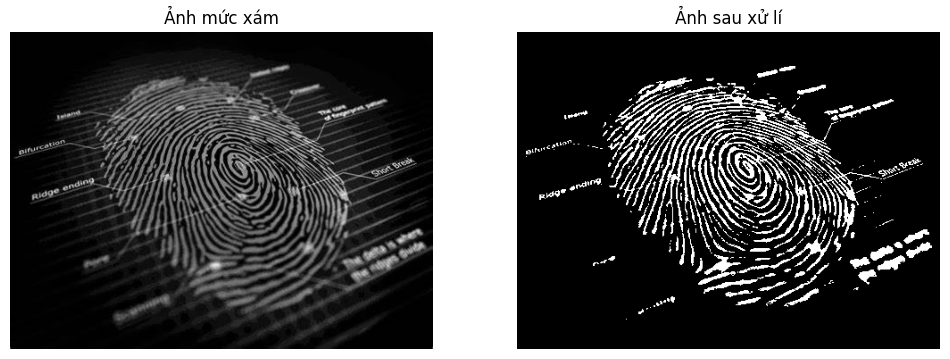

In [22]:
# @title Chuyển đổi ảnh xám thành ảnh nhị phân 1
# Đọc ảnh từ data
anh1 = np.array(cv2.imread(path + 'vantay.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng = 100
xuli1 = nguong_thu_cong(anh1, 100)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh1, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ảnh sau xử lí')
plt.imshow(xuli1, cmap='gray')
plt.axis('off')

plt.show()

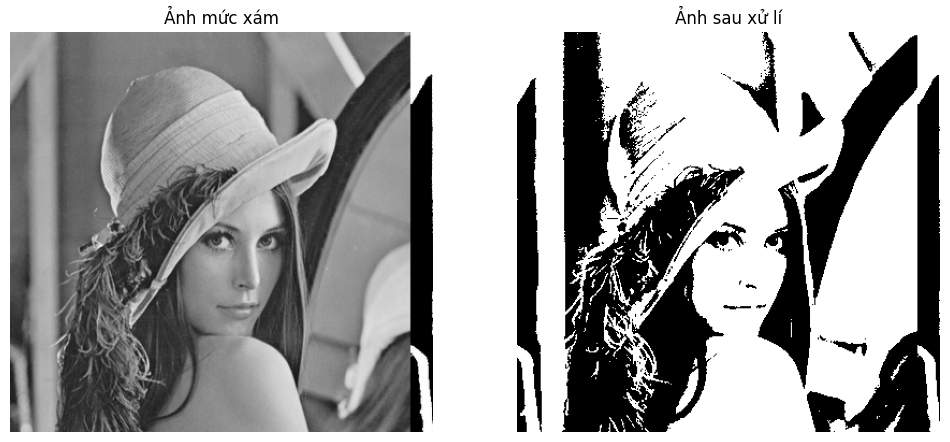

In [23]:
# @title Chuyển đổi ảnh xám thành ảnh nhị phân 2
# Đọc ảnh từ data
anh13 = np.array(cv2.imread(path + 'Picture2.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng otsu
theta13 = nguong_otsu(anh13)
xuli13 = nguong_thu_cong(anh13, theta13)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh13, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ảnh sau xử lí')
plt.imshow(xuli13, cmap='gray')
plt.axis('off')

plt.show()

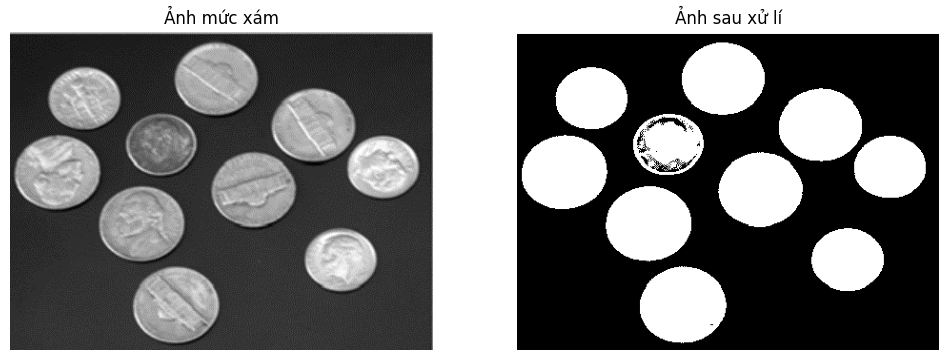

In [24]:
# @title Nhận diện vật thể 1
# Đọc ảnh từ data
anh2 = np.array(cv2.imread(path + 'Picture3.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng tự động
theta2 = nguong_tu_dong(anh2)
xuli2 = nguong_thu_cong(anh2, theta2)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh2, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ảnh sau xử lí')
plt.imshow(xuli2, cmap='gray')
plt.axis('off')

plt.show()

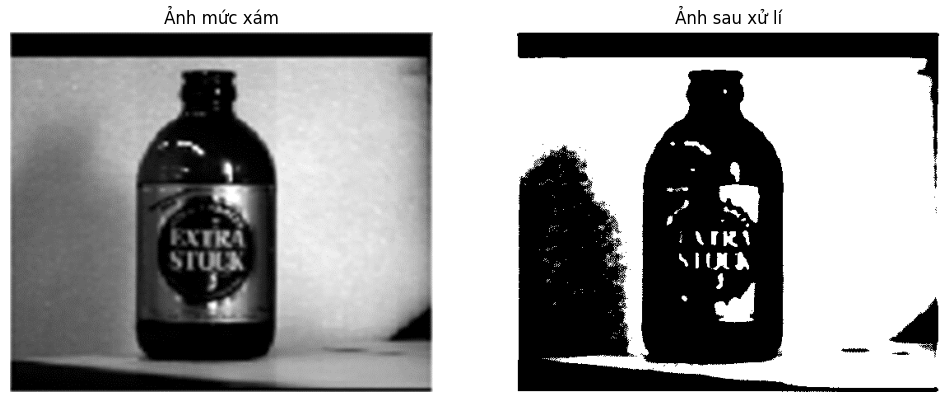

In [25]:
# @title Nhận diện vật thể 2
# Đọc ảnh từ data
anh12 = np.array(cv2.imread(path + 'Picture1.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng otsu
theta12 = nguong_otsu(anh12)
xuli12 = nguong_thu_cong(anh12, theta12)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh12, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ảnh sau xử lí')
plt.imshow(xuli12, cmap='gray')
plt.axis('off')

plt.show()

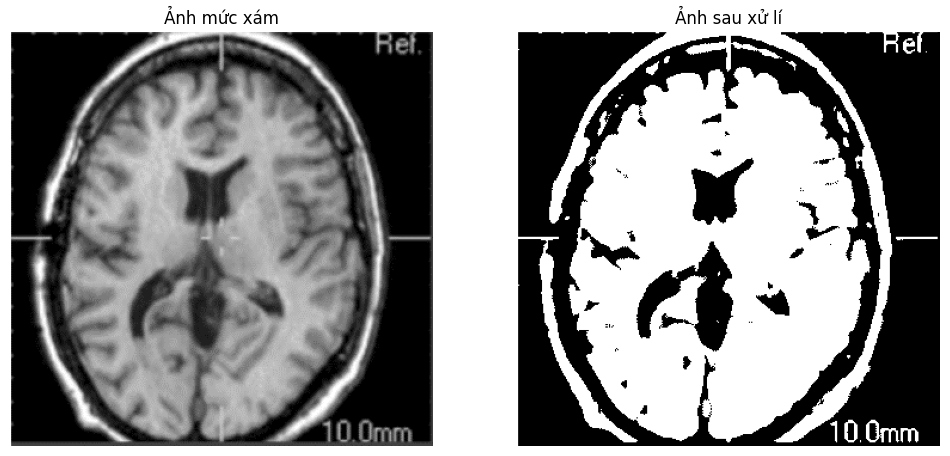

In [27]:
# @title Phân tích ảnh y tế 1
# Đọc ảnh từ data
anh3 = np.array(cv2.imread(path + 'nao.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng otsu
theta3 = nguong_tu_dong(anh3)
xuli3 = nguong_thu_cong(anh3, theta3)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh3, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ảnh sau xử lí')
plt.imshow(xuli3, cmap='gray')
plt.axis('off')

plt.show()

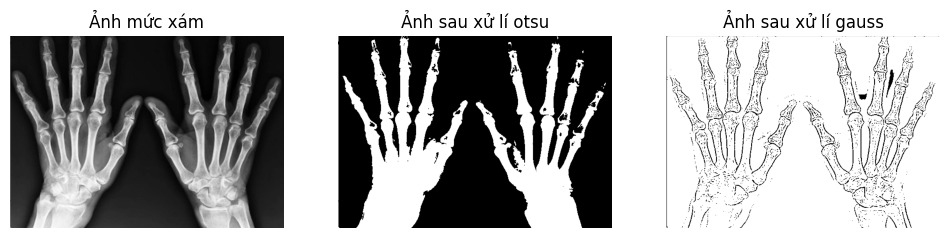

In [38]:
# @title Phân tích ảnh y tế 2
# Đọc ảnh từ data
anh10 = np.array(cv2.imread(path + 'tay.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng otsu
theta101 = nguong_otsu(anh10)
xuli101 = nguong_thu_cong(anh10, theta101)
xuli102 = nguong_thich_ung_gaussian(anh10, 3, 1)

plt.figure(num=3, figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh10, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ảnh sau xử lí otsu')
plt.imshow(xuli101, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Ảnh sau xử lí gauss')
plt.imshow(xuli102, cmap='gray')
plt.axis('off')

plt.show()

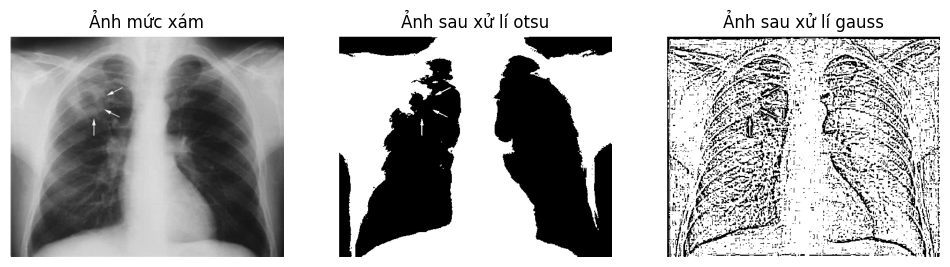

In [39]:
# @title Phân tích ảnh y tế 3
# Đọc ảnh từ data
anh11 = np.array(cv2.imread(path + 'yte.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng otsu
theta111 = nguong_otsu(anh11)
xuli111 = nguong_thu_cong(anh11, theta111)
xuli112 = nguong_thich_ung_gaussian(anh11, 11, 1)

plt.figure(num=3, figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh11, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ảnh sau xử lí otsu')
plt.imshow(xuli111, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Ảnh sau xử lí gauss')
plt.imshow(xuli112, cmap='gray')
plt.axis('off')

plt.show()

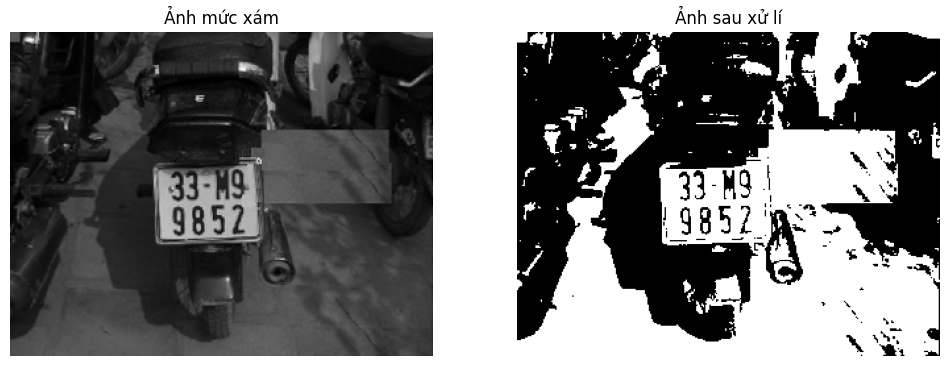

In [40]:
# @title Nhận diện ký tự quang học 1
# Đọc ảnh từ data
anh4 = np.array(cv2.imread(path + 'Picture4.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng otsu
theta4 = nguong_otsu(anh4)
xuli4 = nguong_thu_cong(anh4, theta4)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh4, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ảnh sau xử lí')
plt.imshow(xuli4, cmap='gray')
plt.axis('off')

plt.show()

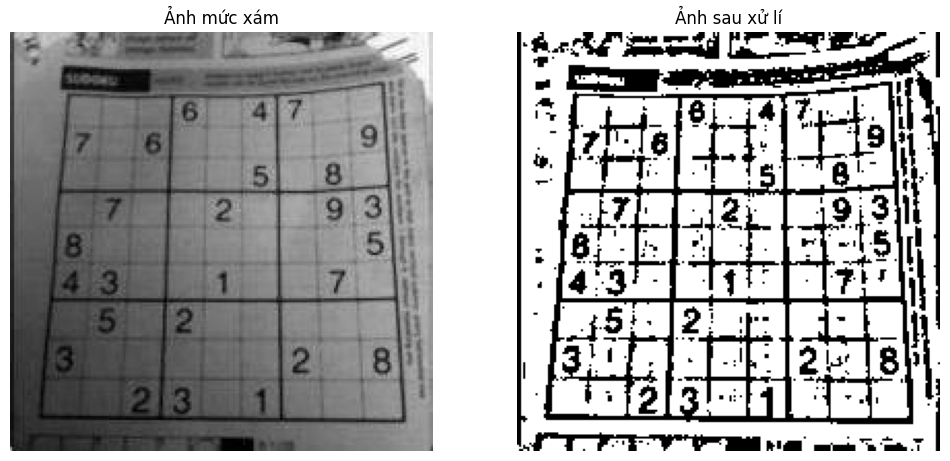

In [41]:
# @title Nhận diện ký tự quang học 2
# Đọc ảnh từ data
anh5 = np.array(cv2.imread(path + 'Picture6.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng thích ứng mean
xuli5 = nguong_thich_ung_mean(anh5, 15, 2)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh5, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ảnh sau xử lí')
plt.imshow(xuli5, cmap='gray')
plt.axis('off')

plt.show()

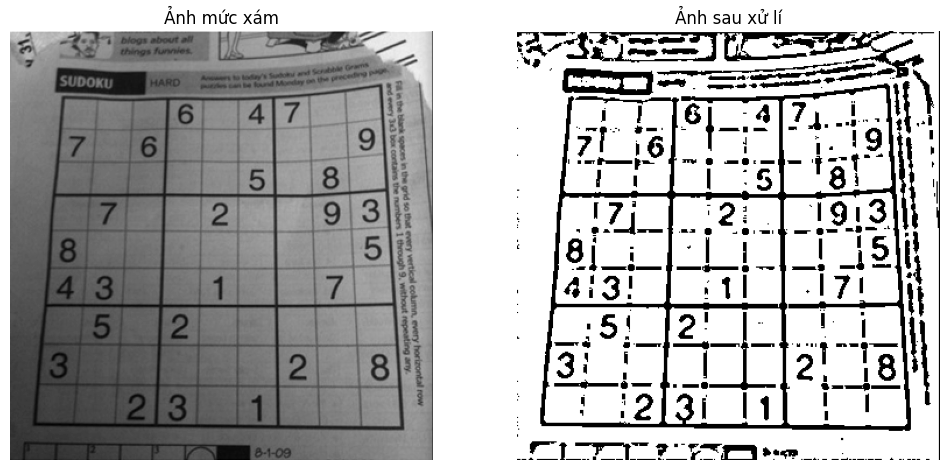

In [42]:
# @title Nhận diện ký tự quang học 2
# Đọc ảnh từ data
anh5 = np.array(cv2.imread(path + 'sudoku.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng thích ứng gaussian
xuli5 = phep_loc_trung_vi(anh5, (5, 5))
xuli5 = nguong_thich_ung_gaussian(xuli5, 15, 2)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh5, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ảnh sau xử lí')
plt.imshow(xuli5, cmap='gray')
plt.axis('off')

plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


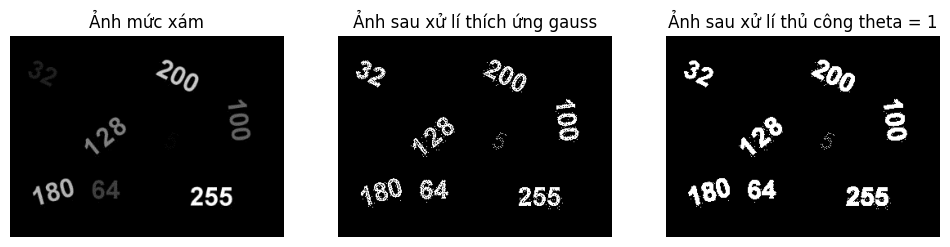

In [43]:
# @title Nhận diện ký tự quang học 3
# Đọc ảnh từ data
anh8 = np.array(cv2.imread(path + 'so.png', cv2.IMREAD_GRAYSCALE))
print(anh8)
# Phân vùng với ngưỡng thích ứng gauss
xuli81 = nguong_thich_ung_gaussian(anh8, 3, 1)
xuli82 = nguong_thu_cong(anh8, 0.1)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh8, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ảnh sau xử lí thích ứng gauss')
plt.imshow(xuli81, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Ảnh sau xử lí thủ công theta = 1')
plt.imshow(xuli82, cmap='gray')
plt.axis('off')

plt.show()

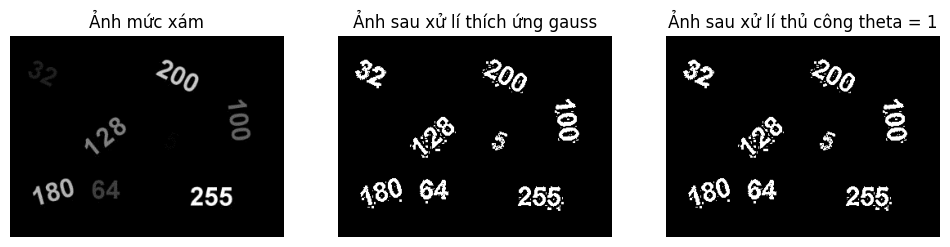

In [45]:
# @title Nhận diện ký tự quang học 3
# Đọc ảnh từ data
anh8 = np.array(cv2.imread(path + 'so.png', cv2.IMREAD_GRAYSCALE))
xuli81 = phep_loc_trung_binh(anh8, (3, 3), 0.5)
xuli81 = nguong_thich_ung_gaussian(xuli81, 3, 0)
xuli82 = nguong_thu_cong(xuli81, 0.1)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh8, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ảnh sau xử lí thích ứng gauss')
plt.imshow(xuli81, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Ảnh sau xử lí thủ công theta = 1')
plt.imshow(xuli82, cmap='gray')
plt.axis('off')

plt.show()

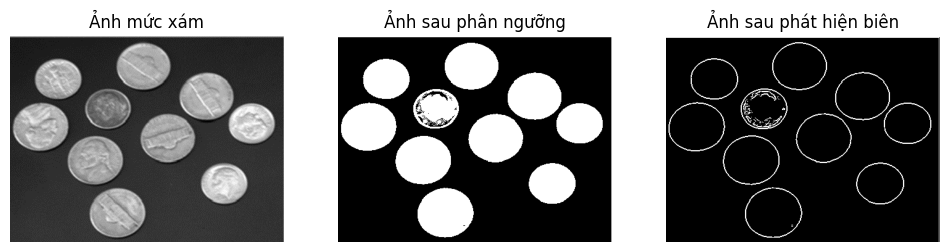

In [48]:
# @title Phát hiện biên 1
# Đọc ảnh từ data
anh6 = np.array(cv2.imread(path + 'Picture3.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng otsu
theta6 = nguong_otsu(anh6)
anh6_nguong = nguong_thu_cong(anh6, theta6)
xuli6 = bien_sobel(anh6_nguong)

plt.figure(num=3, figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh6, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ảnh sau phân ngưỡng')
plt.imshow(anh6_nguong, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Ảnh sau phát hiện biên')
plt.imshow(xuli6, cmap='gray')
plt.axis('off')

plt.show()

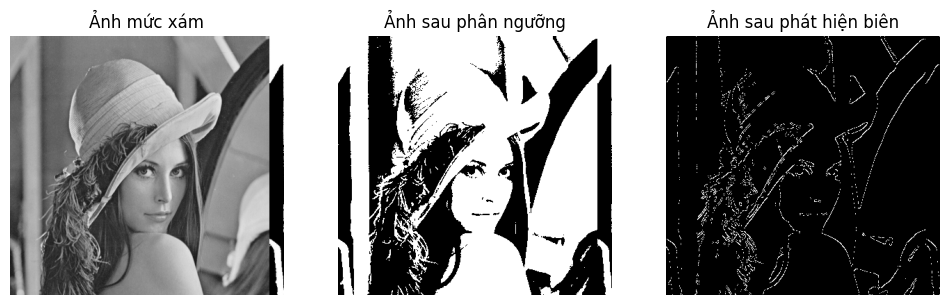

In [50]:
# @title Phát hiện biên 2
# Đọc ảnh từ data
anh7 = np.array(cv2.imread(path + 'Picture2.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng otsu
theta7 = nguong_otsu(anh7)
anh7_nguong = nguong_thu_cong(anh7, theta7)
xuli7 = bien_sobel(anh7_nguong)

plt.figure(num=3, figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh7, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ảnh sau phân ngưỡng')
plt.imshow(anh7_nguong, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Ảnh sau phát hiện biên')
plt.imshow(xuli7, cmap='gray')
plt.axis('off')

plt.show()

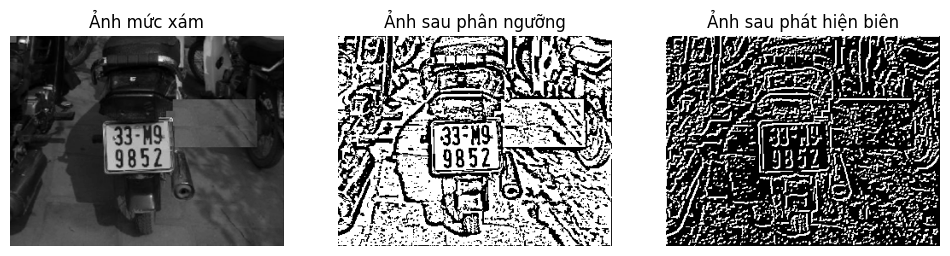

In [51]:
# @title Phát hiện biên 3
# Đọc ảnh từ data
anh14 = np.array(cv2.imread(path + 'Picture4.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng thích ứng gauss
anh14_nguong = nguong_thich_ung_gaussian(anh14, 15, 1)
xuli14 = bien_prewitt(anh14_nguong, 100)


plt.figure(num=3, figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh14, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ảnh sau phân ngưỡng')
plt.imshow(anh14_nguong, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Ảnh sau phát hiện biên')
plt.imshow(xuli14, cmap='gray')
plt.axis('off')

plt.show()

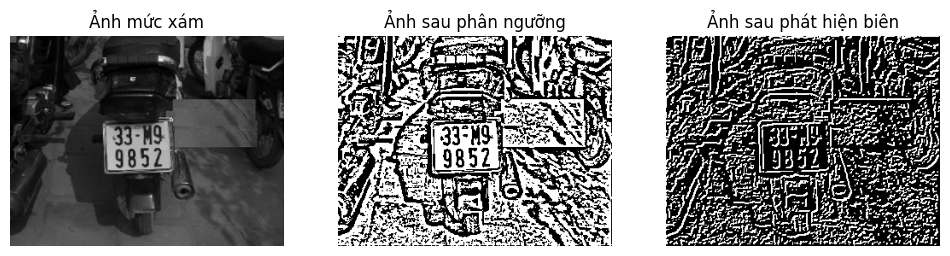

In [52]:
# @title Phát hiện biên 3
# Đọc ảnh từ data
anh14 = np.array(cv2.imread(path + 'Picture4.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng thích ứng gauss
anh14_nguong = cv2.adaptiveThreshold(anh14, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 1)
xuli14 = bien_prewitt(anh14_nguong, 100)


plt.figure(num=3, figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh14, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ảnh sau phân ngưỡng')
plt.imshow(anh14_nguong, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Ảnh sau phát hiện biên')
plt.imshow(xuli14, cmap='gray')
plt.axis('off')

plt.show()

# Phát hiện biên ngưỡng thích ứng


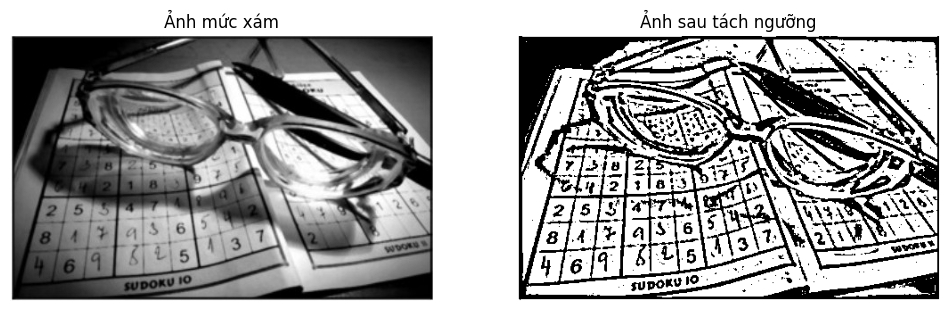

In [53]:
# Đọc ảnh từ data
anh9 = np.array(cv2.imread(path + 'Picture7.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng thích ứng gaussian
xuli9 = nguong_thich_ung_gaussian(anh9, 15, 2)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh9, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ảnh sau tách ngưỡng')
plt.imshow(xuli9, cmap='gray')
plt.axis('off')

plt.show()

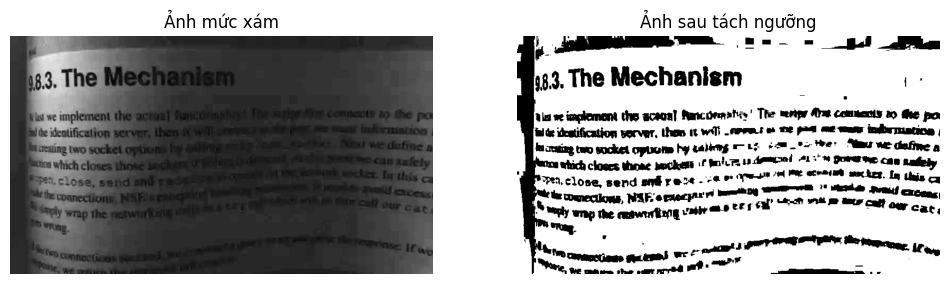

In [58]:
# Đọc ảnh từ data
anh14 = np.array(cv2.imread(path + 'Picture5.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng thích ứng Gaussian
xuli14 = nguong_thich_ung_gaussian(anh14, 115, 1)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh14, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ảnh sau tách ngưỡng')
plt.imshow(xuli14, cmap='gray')
plt.axis('off')

plt.show()

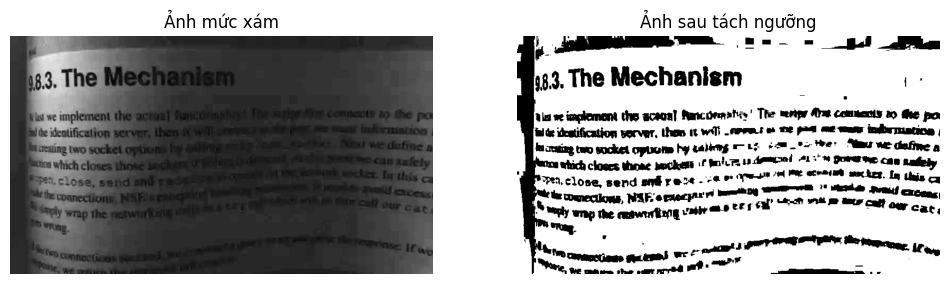

In [59]:
# Đọc ảnh từ data
anh14 = np.array(cv2.imread(path + 'Picture5.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng thích ứng Gaussian
xuli14 = phep_loc_trung_vi(anh14, (5, 5), 0)
xuli14 = nguong_thich_ung_gaussian(anh14, 115, 1)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh14, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ảnh sau tách ngưỡng')
plt.imshow(xuli14, cmap='gray')
plt.axis('off')

plt.show()

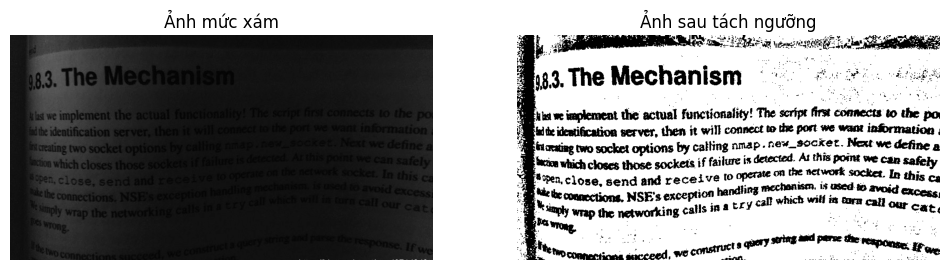

In [57]:
# Đọc ảnh từ data
anh14 = np.array(cv2.imread(path + 'toi.png', cv2.IMREAD_GRAYSCALE))[:-25]
# Phân vùng với ngưỡng thi
# xuli14 = phep_loc_trung_vi(anh14, (5, 5), 0)
xuli14 = nguong_thich_ung_gaussian(anh14, 115, 1)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh14, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ảnh sau tách ngưỡng')
plt.imshow(xuli14, cmap='gray')
plt.axis('off')

plt.show()

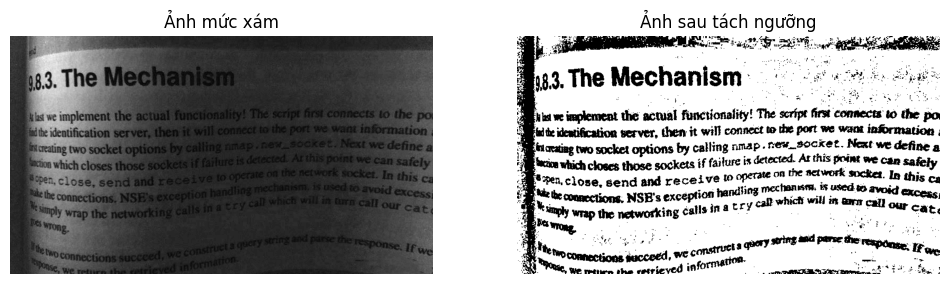

In [56]:
# Đọc ảnh từ data
anh100 = np.array(cv2.imread(path + 'toi6.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng thích ứng Gaussian
xuli14 = nguong_thich_ung_gaussian(anh100, 115, 1)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh100, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ảnh sau tách ngưỡng')
plt.imshow(xuli14, cmap='gray')
plt.axis('off')

plt.show()

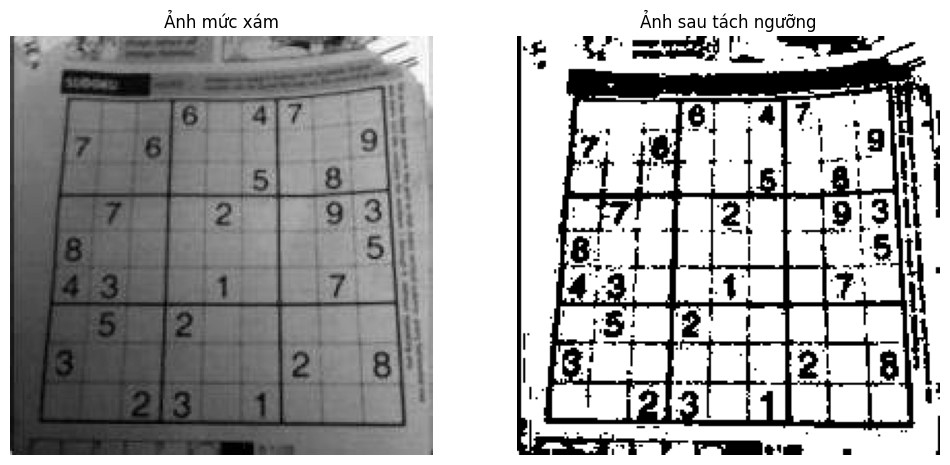

In [60]:
# Đọc ảnh từ data
anh15 = np.array(cv2.imread(path + 'Picture6.png', cv2.IMREAD_GRAYSCALE))
# Phân vùng với ngưỡng gaussian
xuli15 = nguong_thich_ung_gaussian(anh15, 95, 1)

plt.figure(num=2, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Ảnh mức xám')
plt.imshow(anh15, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ảnh sau tách ngưỡng')
plt.imshow(xuli15, cmap='gray')
plt.axis('off')

plt.show()